# Tuning a diffusion model

In this notebook, you will be training a tiny diffusion model, track the training process with MLflow, and tune the hyperparameters using Ray Tune.

## A lightning tour of diffusion models.

Surely, you have heard of diffusion models. It's the architecture behind DALL-E, Stable Diffusion and many others.
Here we are going to look at a particular class of diffusion models, Denoising Diffusion Probabilistic Models (DDPM).

DDPMs aim to generate high-quality samples from a given distribution, typically modeled as an image distribution. These models are based on the idea of denoising a sequence of noisy samples to reach the target distribution. Let's break down the mathematical explanation of DDPM.

1. **Foward Diffusion Process:**
   DDPM introduces a diffusion process to model the generation of samples. It assumes that the data $x$ evolves over a series of steps from an easily generated distribution to the target distribution. This process is defined by a sequence of transformations:

   $$ x_0 \sim p(x_0) $$
   $$ x_t = \sqrt{1 - \beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \epsilon_t $$

   Here, $x_0$ is sampled from an easily generated distribution (e.g., a Gaussian distribution), and $\epsilon_t$ is sampled from a fixed distribution (e.g., Gaussian). The parameter $\beta_t$ controls the step size of the diffusion process.

2. **Reverse Diffusion Process:**
   At each step of the diffusion process, a noise-corrupted version of the data is obtained. The model is then trained to denoise this corrupted sample and estimate the conditional distribution $p_{\theta}(x_t | x_{t-1})$. The denoising process is typically modeled using a neural network.

   $$ p_{\theta}(x_t | x_{t-1}) = \mathcal{N}\left(x_t; \mu_{\theta}(x_{t-1}), \Sigma_{\theta}(x_{t-1})\right) $$

   Here, $\mu_{\theta}$ and $\Sigma_{\theta}$ are functions parameterized by the neural network, which outputs the mean and standard deviation of the conditional distribution.

3. **Training Procedure:**
   During training, we corrupt input samples and train the model to de-noise the inputs again.

4. **Sampling:**
   Once the model is trained, sampling from the model involves running the diffusion process forward and denoising at each step to generate high-quality samples.

In summary, DDPM combines the diffusion process with a denoising neural network to model complex distributions. The training involves optimizing the model parameters to denoise corrupted samples and generate samples from the target distribution. For an in-depth explanation, we recommend Lilian Weng's blog post ["What are Diffusion Models?"](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) and the huggingface blog post ["The Annotated Diffusion Model"](https://huggingface.co/blog/annotated-diffusion).

To train a DDPM, we need two components: a noise scheduler (that adds & removes noise) and a (denoising) model.

### Noise Scheduler

DPPMs feature a forward and a backward diffusion process. The noise scheduler implements the steps for both processes, you can find its implementation in the next cell. 

#### Forward diffusion process

In the forward diffusion process, a small amount of (Gaussian) noise is added in $T$ steps. This yields a sequence of noisy samples $x_1, \dots, x_T$. The step size is controlled by the noise (or variance) schedule $\{\beta_t \in (0, 1)\}^T_{t=1}$.

We will be using a linear noise schedule (the $\beta$ are linearly spaced). Of course, plenty of other options exist.
There's a handy closed-form formula for sampling $x_t$ at any time step, which uses the [reparametrization trick](https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick): If we define $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$, it turns out that $x_t$ is given by

$$
\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
$$

where $\epsilon_t$ is some isotropic Gaussian noise. This is implemented in the `add_noise` method.

#### Reverse diffusion process

We can recreate the original sample $\mathbf{x}_0$, if we manage to reverse the process and sample from $q(\mathbf{x}_{t-1}\vert \mathbf{x}_t)$. Unfortunately, this is not feasible, so we need to learn some model $p_\theta$ which runs the _denoising_ or _reverse diffusion process_: 

$$
p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) \quad
p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))
$$

The reverse diffusion process becomes tractable when we condition on $\mathbf{x}_0$ and one can then derive ["nice"](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#nice) equations for the reverse process, but we'll spare you the Gaussian jugglery.

#### What really matters

The details are not important for our application here. What _is_ important is that we already have three hyperparameters: The number of steps $T$ and the initial and final noise levels $\beta_1$ and $\beta_T$.

In [3]:
import torch


class NoiseScheduler:
    def __init__(
        self, T: int = 100, beta_0: float = 0.0001, beta_T: float = 0.02
    ) -> None:
        self.T = T
        self.betas = torch.linspace(beta_0, beta_T, T)

        # Reparametrization trick: alpha_t = 1 - beta_t
        self.alphas = 1 - self.betas
        # Cumulative product of alphas (the alpha with the bar in the text above).
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        # Shifted alpha_bar; this is just an implementation trick to avoid using the
        # cumprod function at each iteration.
        self.alpha_bars_prev = torch.cat([torch.tensor([1.0]), self.alphas_bar[:-1]])

        # The coefficients for the forward process.
        self.sqrt_alphas_bar = self.alphas_bar**0.5
        self.sqrt_one_minus_alphas_bar = (1 - self.alphas_bar) ** 0.5

        # The coefficients for the backward process.
        self.sqrt_inv_alphas = torch.sqrt(1 / self.alphas)
        self.epsilon_coeff = self.betas / torch.sqrt(1 - self.alphas_bar)
        self.sigmas = torch.sqrt(
            self.betas * (1.0 - self.alpha_bars_prev) / (1.0 - self.alphas_bar)
        )

    def add_noise(
        self, x_0: torch.Tensor, epsilon: torch.Tensor, t: int
    ) -> torch.Tensor:
        return (
            self.sqrt_alphas_bar[t] * x_0 + epsilon * self.sqrt_one_minus_alphas_bar[t]
        )

    def remove_noise(
        self, x_t: torch.Tensor, epsilon: torch.Tensor, t: int
    ) -> torch.Tensor:
        mu_tilde_t = self.sqrt_inv_alphas[t] * (x_t - self.epsilon_coeff[t] * epsilon)
        sigma_t = self.sigmas[t]
        z = torch.randn_like(epsilon)
        return mu_tilde_t + sigma_t * z

    def __len__(self):
        return self.T

### Denoising model

As mentioned above, the denoising model is required to drive reverse process. More sophisticated diffusion models will use elaborate methods to embed time and inputs. Here, we'll use a simple MLP and ignore these intricacies.

In [4]:
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int = 3,
        hidden_dim: int = 64,
        output_dim: int = 2,
        num_hidden_layers: int = 2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x: torch.Tensor, t: int) -> torch.Tensor:
        """
        Args:
            x: The (noisy) input sample .
            t: The current time step.

        Returns:
            The de-noised input sample.
        """
        t_tensor = torch.full((x.shape[0], 1), t, dtype=torch.float32)
        x = torch.cat((x, t_tensor), dim=-1)
        for layer in self.layers[:-1]:
            x = F.gelu(layer(x))
        return self.layers[-1](x)

We can extend our list of hyperparameters with the number of hidden layers and the hidden layer dimension.

## Training a diffusion model

Now that we have the model, we of course want to train it. For this we need data, and since we are on a tight time and GPU budget, we'll use 2D point clouds - ours has a peculiar shape. 🤔 

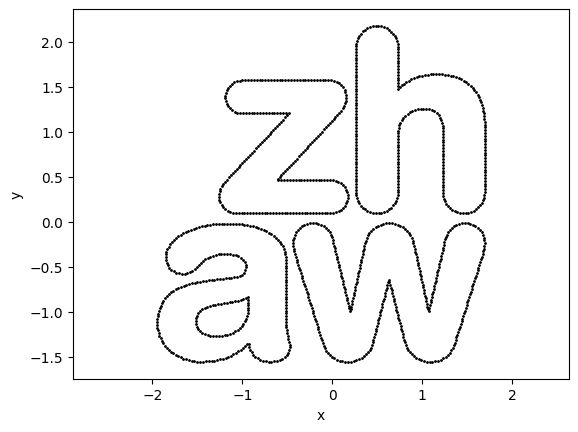

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

zhaw_logo = pd.read_csv("data/zhaw_logo.csv")
points = zhaw_logo.assign(y=lambda df: -df.y)
points -= points.mean()
points /= points.std()
points.plot(kind="scatter", x="x", y="y", color="black", s=1).axis("equal")
plt.show()

In [6]:
from torch.utils.data import TensorDataset 
dataset = TensorDataset(
    torch.tensor(points.values, dtype=torch.float32)
)

Training works as follows:

1. Select a random time step $t$ between $0$ and $T-1$.
2. Add noise to the input at $t$.
3. Predict the noise using the model.
4. Compute the loss.
5. Backpropagate the loss.

The training loop is implemented in the cell below, but lacks tracking. Add missing code!

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm

# TODO: Import and set up MLflow
import mlflow

mlflow.set_tracking_uri("http://localhost:8080")
diffusion_experiment = mlflow.set_experiment("diffusion_models")

run_name = "diffusion_experiment_1"
artifact_path = "diffusion_model"

config = {
    "epochs": 10000,
    "batch_size": 4196,
    "learning_rate": 0.001,
    # ... other hyperparameters ...
}

ddpm = MLP(input_dim=3, hidden_dim=64, output_dim=2, num_hidden_layers=3)
noise_schedule = NoiseScheduler(T=10, beta_0=0.0001, beta_T=0.02)

dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["learning_rate"])
criterion = nn.MSELoss()

# TODO: Log hyperparameters and metrics with MLflow
with mlflow.start_run(run_name=run_name, tags={"model": "Diffusion"}) as run:
    mlflow.log_params(config)

    with tqdm(total=config["epochs"]) as progress_bar:
        for epoch in range(config["epochs"]):
            ddpm.train()
            train_loss = 0
            for batch in dataloader:
                batch = batch[0]

                # Select a random time step
                t = torch.randint(low=0, high=len(noise_schedule), size=(1,)).item()

                # Add noise to the batch
                epsilon_target = torch.randn(batch.shape)
                x_t_plus_1 = noise_schedule.add_noise(batch, epsilon_target, t)

                # Predict the noise
                epsilon_pred = ddpm(x_t_plus_1, t)

                # Compute the loss: the difference between the predicted noise and the target noise
                loss = criterion(epsilon_pred, epsilon_target)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            train_loss /= len(dataloader)
            # TODO: Log the loss with MLflow
            mlflow.log_metric('loss', train_loss, step=epoch)
            
            progress_bar.set_postfix({"loss": f"{train_loss:.4f}"})
            progress_bar.update(1)

    # TODO: Log the model and final loss with MLflow
    mlflow.pytorch.log_model(ddpm, artifact_path=artifact_path)

2025/03/18 14:45:43 INFO mlflow.tracking.fluent: Experiment with name 'Diffusion_models' does not exist. Creating a new experiment.


  0%|          | 0/10000 [00:00<?, ?it/s]

2025/03/18 14:47:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run diffusion_experiment_1 at: http://localhost:8080/#/experiments/337909402145741359/runs/86f347f129814000a95119033c7aa88c
🧪 View experiment at: http://localhost:8080/#/experiments/337909402145741359


In the next cell, we sample the DDPM. BY moving the slider, you can step through the de-noising process.

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

x_last = torch.randn(5000, 2)
samples = [x_last]
for t in reversed(range(len(noise_schedule))):
    with torch.no_grad():
        residual = ddpm(samples[-1], t)
    samples.append(noise_schedule.remove_noise(samples[-1], residual, t))

def update_plot(t, show_line):
    plt.clf()
    plt.scatter(samples[t][:, 0], samples[t][:, 1], color='#0064a6', s=1)
    if show_line:
        plt.scatter(points['x'], points['y'], color='black', s=1)
    plt.axis('equal')
    plt.show()

slider = widgets.IntSlider(min=0, max=len(samples)-1, step=1, value=0)
toggle_button = widgets.ToggleButton(value=False, description='Show ground truth')
widgets.interact(update_plot, t=slider, show_line=toggle_button)

As you can see, our approach works, but it the model is not perfect yet. To improve on our first model, let's tune some hyperparameters. Below, you can find the template from the previous notebook on Ray Tune. Your tasks are the following:

[Evaluating](https://huggingface.co/docs/diffusers/conceptual/evaluation) generative models is challenging. Here, we refrain from implementing any sophisticated method and instead ask you to implement the following: compute summary statistics (mean in $x$, mean in $y$, standard deviation in $x$, standard deviation in $y$) and aim for a model that reproduces the ones from the training data. As the training data is normalized, the means are both 0 and the standard deviations are 1.

1. Implement the trainable by copying the training loop from above. Instead of logging directly to MLflow, use the MLflow logger introduced earlier. 
2. Select a range of hyperparameters to tune. Some good candidates are the learning rate, $T$, $\beta_0$, $\beta_T$, and the parameters of the MLP. Define your `search_space`.
3. Select a search algorithm and optionally a scheduler. We tested `HEBO`, but you are free to choose.

Enjoy! :D

In [19]:
from ray.air.integrations.mlflow import MLflowLoggerCallback

run_config_with_callback = train.RunConfig(
    name="MLFlow logging experiment",
    callbacks=[MLflowLoggerCallback(
        tracking_uri="http://localhost:8080",
        experiment_name="diffusion-ray-tune-experiments",
        save_artifact=True
    )],
)

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from ray import tune, train
from ray.tune.search.hebo import HEBOSearch
from tqdm import tqdm

def compute_stats(output):
    """Compute mean and standard deviation of the model's output."""
    mean_x = output[:, 0].detach().numpy().mean()
    mean_y = output[:, 1].detach().numpy().mean()
    std_x = output[:, 0].detach().numpy().std()
    std_y = output[:, 1].detach().numpy().std()
    return mean_x, mean_y, std_x, std_y

def trainable(config):
    # Initialize model and noise scheduler
    ddpm = MLP(input_dim=3, hidden_dim=64, output_dim=2, num_hidden_layers=3)
    noise_schedule = NoiseScheduler(T=config['T'], beta_0=config['beta_0'], beta_T=config['beta_T'])

    # Prepare dataset
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=config['lr'])
    criterion = nn.MSELoss()

    # Training loop
    with tqdm(total=config["epochs"], desc="Training Progress") as progress_bar:
        for epoch in range(config["epochs"]):
            ddpm.train()
            train_loss = 0
            mean_x, mean_y, std_x, std_y = 0, 0, 0, 0

            for batch in dataloader:
                batch = batch[0]

                # Sample a random time step
                t = torch.randint(low=0, high=len(noise_schedule), size=(1,)).item()

                # Add noise to the input
                epsilon_target = torch.randn(batch.shape)
                x_t_plus_1 = noise_schedule.add_noise(batch, epsilon_target, t)

                # Predict noise
                epsilon_pred = ddpm(x_t_plus_1, t)

                # Compute the loss: the difference between the predicted noise and the target noise
                loss = criterion(epsilon_pred, epsilon_target)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Get the train loss
                train_loss += loss.item()

                # Compute summary statistics
                mean_x, mean_y, std_x, std_y = compute_stats(epsilon_pred)
                for metric in [mean_x, mean_y, std_x, std_y]:
                    metric += metric
            
            # Compute average loss per epoch
            avg_loss = train_loss / len(dataloader)

            # Compute mean and std of x and y per epoch
            for metric in [mean_x, mean_y, std_x, std_y]:
                metric /= len(dataloader)

            train.report({"Epoch": epoch+1, "avg_loss": avg_loss, "mean_x": mean_x, "mean_y": mean_y, "std_x": std_x, "std_y": std_y})
            progress_bar.set_description(f'Epoch {epoch+1} | Loss: {avg_loss:.4f} | Mean of X: {mean_x:.4f} | Mean of Y: {mean_y:.4f} | Std. of X: {std_x:.4f} | Std. of Y: {std_y:.4f}')
            progress_bar.update(1)
            
    return avg_loss

search_space = {
    'epochs': 10000,
    'batch_size': tune.choice([512, 1024, 2048, 4096]),
    'lr': tune.choice([0.001, 0.01, 0.1]),
    'T': tune.choice([25, 50, 75, 100]),
    'beta_0': tune.choice([0.0001, 0.001]),
    'beta_T': tune.choice([0.02, 0.2])
}

algo = HEBOSearch()
scheduler = tune.schedulers.ASHAScheduler()

tune_config = tune.TuneConfig(
    metric='avg_loss',
    mode="min",
    search_alg=algo,
    scheduler=scheduler,
    num_samples=10,
)

run_config = train.RunConfig()

tuner = tune.Tuner(
    trainable=trainable,
    tune_config=tune_config,
    run_config=run_config,
    param_space=search_space,
)

results = tuner.fit()

2025-03-19 09:12:26,645	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/jaron/ray_results/trainable_2025-03-19_09-11-56' in 0.0174s.
2025-03-19 09:12:26,648	INFO tune.py:1041 -- Total run time: 30.48 seconds (30.44 seconds for the tuning loop).


In [16]:
results.get_best_result()

Result(
  metrics={'Epoch': 100, 'avg_loss': 0.2534799948334694, 'mean_x': 0.21555567, 'mean_y': 0.103880174, 'std_x': 0.9596064, 'std_y': 0.9374113},
  path='/Users/jaron/ray_results/trainable_2025-03-19_09-08-38/trainable_52604d6c_2_T=25,batch_size=1024,beta_0=0.0010,beta_T=0.2000,epochs=100,lr=0.0010_2025-03-19_09-08-40',
  filesystem='local',
  checkpoint=None
)

In [17]:
results.get_best_result().config

{'epochs': 100,
 'batch_size': 1024,
 'lr': 0.001,
 'T': 25,
 'beta_0': 0.001,
 'beta_T': 0.2}